In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import matplotlib as mpl

In [61]:
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (10.0, 7.0)
sns.set_palette("Dark2")

In [3]:
def deep_learning_cv_score(df):
    scores_cv_long = []
    for i in range(5):
        scores_multi_protein_cv_c = df[
            df['run'] == f'cv_{i}'].reset_index(drop=True)

        max_epoch = scores_multi_protein_cv_c.groupby(
            ['epoch']).median()['val_score'].reset_index()
        max_epoch = np.squeeze(max_epoch[max_epoch['val_score'] ==
                                         max_epoch['val_score'].max()]['epoch'])
        scores_cv_long.append(df[
            (df['run'] == f'cv_{i}')
            & (df['epoch'] == max_epoch)].reset_index(drop=True))
    scores_cv_long = pd.concat(scores_cv_long).drop(['epoch', 'mae'], axis=1)
    scores_cv_long['model'] = 'DL'
    return scores_cv_long

In [6]:
fda_drugs = pd.read_csv("../data/drug/drug_info.csv")
fda_drugs = fda_drugs[fda_drugs['FDA_Approved']=='Yes']['drug_id'].values

# ln_IC50

## test set

### model comparison

In [22]:
test_df_protein_list = []
col = ['drug_id', 'test_corr']

scores_en_protein = pd.read_csv("../work_dirs/protein/ElasticNet/scores_202006061215_ruv_min_300.csv")[col]
scores_en_protein['model'] = 'ENet'
scores_en_protein['data'] = 'protein'
scores_en_protein = scores_en_protein[scores_en_protein['drug_id'].isin(fda_drugs)]

scores_rf_protein = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006051013_ruv_min_300.csv")[col]
scores_rf_protein['model'] = 'RF'
scores_rf_protein['data'] = 'protein'
scores_rf_protein = scores_rf_protein[scores_rf_protein['drug_id'].isin(fda_drugs)]

tmp_df = pd.concat([scores_en_protein, scores_rf_protein])
test_df_protein_list.append(tmp_df[tmp_df['drug_id'].isin(fda_drugs)])

scores_multi_protein = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006060123_resx_ruv_zero_300.csv"
)
scores_multi_protein = scores_multi_protein[scores_multi_protein['drug_id'].isin(fda_drugs)]
scores_multi_protein_test = scores_multi_protein[
    scores_multi_protein['run'] == 'test'].reset_index(drop=True).rename(
        columns={'corr': 'test_corr'})
tmp_df = scores_multi_protein_test[scores_multi_protein_test['epoch']
                                        == 70][col].reset_index(drop=True)
tmp_df['model'] = 'DL'
tmp_df['data'] = 'protein'
test_df_protein_list.append(tmp_df)

test_corr_df_protein = pd.concat(test_df_protein_list)
test_corr_df_protein['key'] = test_corr_df_protein.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

In [23]:
test_df_rna_list = []
col = ['drug_id', 'test_corr']

scores_en_rna = pd.read_csv("../work_dirs/rna/ElasticNet/scores_202006081309_rna_300.csv")[col]
scores_en_rna['model'] = 'ENet'
scores_en_rna['data'] = 'RNA'
scores_en_rna = scores_en_rna[scores_en_rna['drug_id'].isin(fda_drugs)]

scores_rf_rna = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006051532_rna_300.csv")[col]
scores_rf_rna['model'] = 'RF'
scores_rf_rna['data'] = 'RNA'
scores_rf_rna = scores_rf_rna[scores_rf_rna['drug_id'].isin(fda_drugs)]

tmp_df = pd.concat([scores_en_rna, scores_rf_rna])
test_df_rna_list.append(tmp_df)

scores_multi_rna = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006072037_res.csv"
)
scores_multi_rna = scores_multi_rna[scores_multi_rna['drug_id'].isin(fda_drugs)]

scores_multi_rna_test = scores_multi_rna[
    scores_multi_rna['run'] == 'test'].reset_index(drop=True).rename(
        columns={'corr': 'test_corr'})
tmp_df = scores_multi_rna_test[scores_multi_rna_test['epoch']
                                        == 210][col].reset_index(drop=True)
tmp_df['model'] = 'DL'
tmp_df['data'] = 'RNA'
test_df_rna_list.append(tmp_df)

test_corr_df_rna = pd.concat(test_df_rna_list)
test_corr_df_rna['key'] = test_corr_df_rna.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

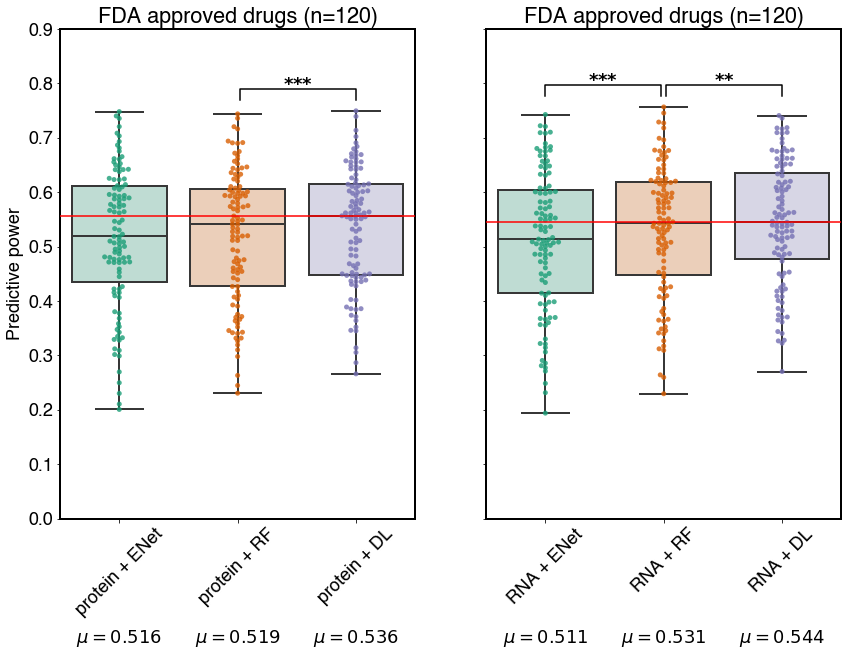

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharey=True)
ga = sns.boxplot('key',
                 'test_corr',
                 data=test_corr_df_protein,
                 orient='v',
                 linewidth=2,
                 ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_protein,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 1.02, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_protein['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.01,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
y = test_corr_df_protein[test_corr_df_protein['key'] ==
                         'protein + DL']['test_corr'].median()
ax[0].plot((-0.5, 2.5), [y, y], color='red', zorder=10)
ax[0].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_protein[test_corr_df_protein['key']=='protein + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[0].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_protein[test_corr_df_protein['key']=='protein + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[0].text(
    2,
    -0.22,
    f"$\mu={test_corr_df_protein[test_corr_df_protein['key']=='protein + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

# RNA
ga = sns.boxplot('key',
                 'test_corr',
                 data=test_corr_df_rna,
                 orient='v',
                 linewidth=2,
                 ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_rna,
              orient='vh',
              alpha=.8,
              ax=ax[1])

x1, x2 = 0, 0.98  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_rna['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.01,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
x1, x2 = 1.02, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_rna['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.01,
           r"$\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
y = test_corr_df_rna[test_corr_df_rna['key'] ==
                     'RNA + DL']['test_corr'].median()
ax[1].plot((-0.5, 2.5), [y, y], color='red', zorder=10)
ax[1].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_rna[test_corr_df_rna['key']=='RNA + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[1].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_rna[test_corr_df_rna['key']=='RNA + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[1].text(
    2,
    -0.22,
    f"$\mu={test_corr_df_rna[test_corr_df_rna['key']=='RNA + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

ax[0].set_ylabel('Predictive power')
ax[0].set_xlabel('')
ax[0].set_title('FDA approved drugs (n=120)')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('FDA approved drugs (n=120)')
plt.ylim(0, .9)
fig.autofmt_xdate(rotation=45, ha='center')
plt.savefig("../plots/Fig4S-C.pdf", dpi=500)

In [25]:
ttest_rel(test_corr_df_protein[test_corr_df_protein['key']=='protein + ENet']['test_corr'].values,
          test_corr_df_protein[test_corr_df_protein['key']=='protein + RF']['test_corr'].values)

Ttest_relResult(statistic=-0.674832780737846, pvalue=0.5012512865205436)

In [11]:
ttest_rel(test_corr_df_rna[test_corr_df_rna['key']=='RNA + ENet']['test_corr'].values,
          test_corr_df_rna[test_corr_df_rna['key']=='RNA + RF']['test_corr'].values)

Ttest_relResult(statistic=-3.469703393442599, pvalue=0.0007545876258159301)

In [14]:
ttest_rel(test_corr_df_protein[test_corr_df_protein['key']=='protein + RF']['test_corr'].values,
          test_corr_df_protein[test_corr_df_protein['key']=='protein + DL']['test_corr'].values)

Ttest_relResult(statistic=-4.018878155139682, pvalue=0.00010962678109714607)

In [13]:
ttest_rel(test_corr_df_rna[test_corr_df_rna['key']=='RNA + RF']['test_corr'].values,
          test_corr_df_rna[test_corr_df_rna['key']=='RNA + DL']['test_corr'].values)

Ttest_relResult(statistic=-2.659347261284888, pvalue=0.009043784027997864)

### data comparison

In [26]:
col = ['drug_id', 'test_corr']

In [27]:
test_corr_df_en = pd.concat([scores_en_protein, scores_en_rna])

test_corr_df_en['key'] = test_corr_df_en.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

In [28]:
test_corr_df_rf = pd.concat([scores_rf_protein, scores_rf_rna])

test_corr_df_rf['key'] = test_corr_df_rf.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

In [29]:
protein_df = scores_multi_protein_test[scores_multi_protein_test['epoch']
                                        == 70][col].reset_index(drop=True)
protein_df['model'] = 'DL'
protein_df['data'] = 'protein'

rna_df = scores_multi_rna_test[scores_multi_rna_test['epoch']
                                        == 210][col].reset_index(drop=True)
rna_df['model'] = 'DL'
rna_df['data'] = 'RNA'
test_corr_df_dl = pd.concat([protein_df, rna_df])

test_corr_df_dl['key'] = test_corr_df_dl.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

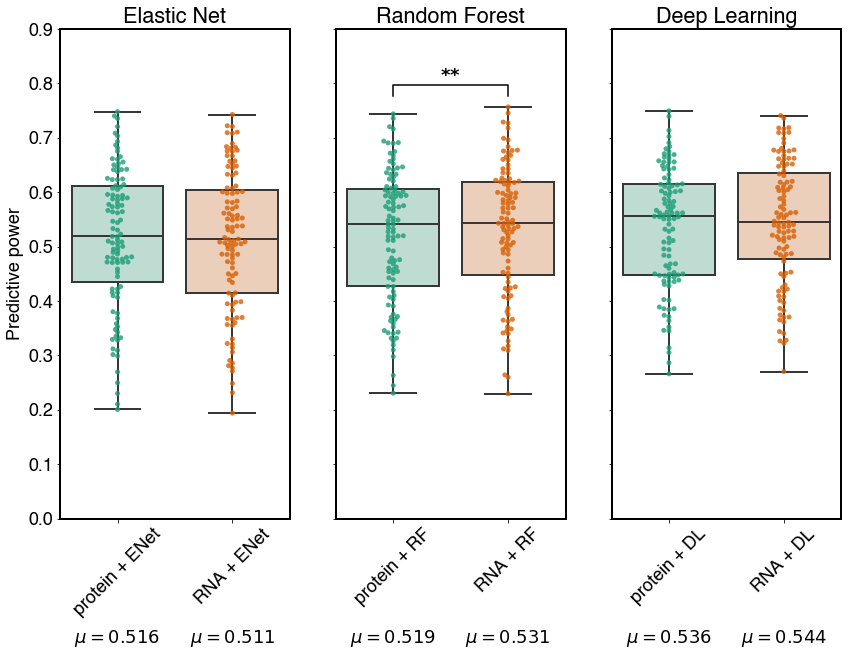

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(14, 10), sharey=True)
# EN
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_en,
            orient='v',
            linewidth=2,
            ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_en,
              orient='vh',
              alpha=.8,
              ax=ax[0])

ax[0].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_en[test_corr_df_en['key']=='protein + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[0].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_en[test_corr_df_en['key']=='RNA + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
# RF
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_rf,
            orient='v',
            linewidth=2,
            ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_rf,
              orient='vh',
              alpha=.8,
              ax=ax[1])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_rf['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
ax[1].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_rf[test_corr_df_rf['key']=='protein + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[1].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_rf[test_corr_df_rf['key']=='RNA + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

# DL
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_dl,
            orient='v',
            linewidth=2,
            ax=ax[2])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_dl,
              orient='vh',
              alpha=.8,
              ax=ax[2])


ax[2].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_dl[test_corr_df_dl['key']=='protein + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[2].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_dl[test_corr_df_dl['key']=='RNA + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

ax[0].set_ylabel('Predictive power')
ax[0].set_xlabel('')
ax[0].set_title('Elastic Net')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('Random Forest')
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_title('Deep Learning')
plt.ylim(0, .9)
fig.autofmt_xdate(rotation=45, ha='center')

In [31]:
ttest_rel(test_corr_df_en[test_corr_df_en['key']=='protein + ENet']['test_corr'].values,
          test_corr_df_en[test_corr_df_en['key']=='RNA + ENet']['test_corr'].values)

Ttest_relResult(statistic=0.7364201557972024, pvalue=0.4631017116632442)

In [32]:
ttest_rel(test_corr_df_rf[test_corr_df_rf['key']=='protein + RF']['test_corr'].values,
          test_corr_df_rf[test_corr_df_rf['key']=='RNA + RF']['test_corr'].values)

Ttest_relResult(statistic=-2.647227114757908, pvalue=0.009353095374865176)

In [33]:
ttest_rel(test_corr_df_dl[test_corr_df_dl['key']=='protein + DL']['test_corr'].values,
          test_corr_df_dl[test_corr_df_dl['key']=='RNA + DL']['test_corr'].values)

Ttest_relResult(statistic=-1.7677870538816054, pvalue=0.07997388447470347)

# protein vs RNA consistency

### protein RNA consistency

In [53]:
test_corr_df_rf_scatter = pd.pivot(test_corr_df_rf, index='drug_id', columns='key', values='test_corr')

In [54]:
test_corr_df_rf_scatter['delta'] = test_corr_df_rf_scatter[
    'protein + RF'] - test_corr_df_rf_scatter['RNA + RF']
test_corr_df_rf_scatter.sort_values(by='delta', ascending=False).head()

key,RNA + RF,protein + RF,delta
drug_id,,,
11,0.229566,0.345714,0.116148
1008,0.502796,0.597942,0.095146
1020,0.520337,0.604308,0.083971
1414,0.259696,0.331685,0.071989
150,0.494768,0.546595,0.051828


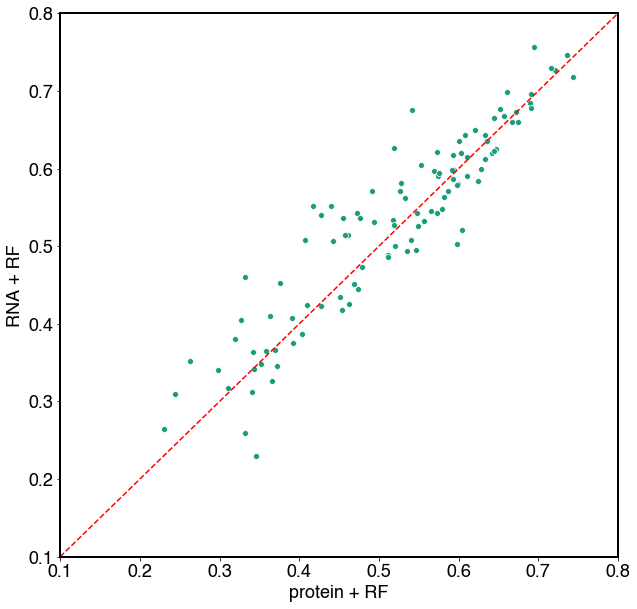

In [56]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein + RF', y='RNA + RF', data=test_corr_df_rf_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')

In [57]:
pearsonr(test_corr_df_rf_scatter['protein + RF'], test_corr_df_rf_scatter['RNA + RF'])

(0.9242368483864682, 1.0446178564420895e-45)

In [58]:
test_corr_df_dl_scatter = pd.pivot(test_corr_df_dl, index='drug_id', columns='key', values='test_corr')

In [59]:
test_corr_df_dl_scatter['delta'] = test_corr_df_dl_scatter[
    'protein + DL'] - test_corr_df_dl_scatter['RNA + DL']
test_corr_df_dl_scatter.sort_values(by='delta', ascending=False).head()

key,RNA + DL,protein + DL,delta
drug_id,,,
1020,0.509885,0.684129,0.174243
1016,0.326647,0.460121,0.133474
2220,0.429894,0.558259,0.128365
1008,0.544773,0.642727,0.097954
1502,0.370074,0.443023,0.072949


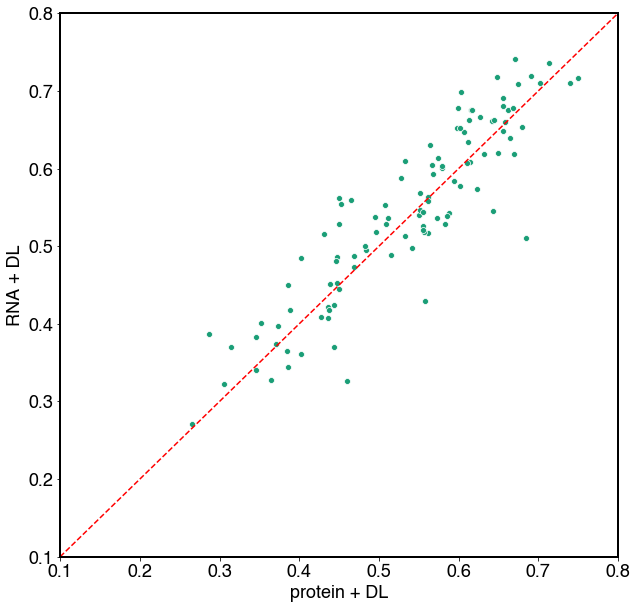

In [60]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein + DL', y='RNA + DL', data=test_corr_df_dl_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')


In [159]:
pearsonr(test_corr_df_dl_scatter['protein + DL'], test_corr_df_dl_scatter['RNA + DL'])

(0.8987136973583052, 1.5965432693412805e-234)

In [166]:
test_corr_df_dl_scatter['delta'] = test_corr_df_dl_scatter[
    'protein + DL'] - test_corr_df_dl_scatter['RNA + DL']
test_corr_df_dl_scatter.sort_values(by='delta', ascending=False).head()

key,RNA + DL,protein + DL,delta
drug_id,,,
1029,0.197453,0.620234,0.422780
1149,0.286321,0.515766,0.229444
1018,0.409210,0.591887,0.182677
2255,0.380139,0.556484,0.176346
1020,0.509885,0.684129,0.174243


In [161]:
pearsonr(test_corr_df_rf_scatter['protein + RF'], test_corr_df_dl_scatter['protein + DL'])

(0.9295314907785805, 2.141993911935631e-283)

In [162]:
pearsonr(test_corr_df_rf_scatter['RNA + RF'], test_corr_df_dl_scatter['RNA + DL'])

(0.9211206996490193, 4.0663885375540677e-268)